In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import argus_shapes
import pulse2percept.implants as p2pi
import pulse2percept.retina as p2pr
import pulse2percept.utils as p2pu

import skimage.io as skio
import skimage.transform as skit

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-06-10 17:20:28,838 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
results_dir = '../../results/shape1cv/'
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))
subjectdata['scale'] = pd.Series([0.5, 1.5, 1.0, 0.6], index=subjectdata.index)
subjectdata

,second_sight_id,implant_x,implant_y,implant_rot,loc_od_x,loc_od_y,xrange,yrange,implant_type,scale
subject_id,,,,,,,,,,
S1,TB,-406,-162,-0.698,17.7,1.680,"(-36.9, 36.9)","(-36.9, 36.9)",<class 'pulse2percept.implants.ArgusI'>,0.5
S2,12-005,-1725,-366,-0.474,15.3,0.922,"(-30.0, 30.0)","(-22.5, 22.5)",<class 'pulse2percept.implants.ArgusII'>,1.5
S3,51-009,249,-486,-0.609,15.0,1.790,"(-32.5, 32.5)","(-24.4, 24.4)",<class 'pulse2percept.implants.ArgusII'>,1.0
S4,52-001,-1502,-227,-0.415,16.9,2.500,"(-32.0, 32.0)","(-24.0, 24.0)",<class 'pulse2percept.implants.ArgusII'>,0.6


In [3]:
subjects = subjectdata.index.sort_values()

In [4]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'best_train_cost': specifics['best_train_score'][0],
            'idx_fold': specifics['idx_fold'],
            'y_test': y,
            'y_pred': y_pred,
            'n_samples': len(y),
            'n_folds': specifics['n_folds'],
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
        [row.update(bp) for bp in best_params]
        data.append(row)
    return pd.DataFrame(data)

In [5]:
def calc_test_cost(grouped_data, verbose=True):
    compact_data = []
    for (subject, model), data in grouped_data:
        if verbose:
            print('- Processing %s, %s %s' % (subject, model, adjust_bias))
        # Aggregate test data from all folds:
#         xyrange = np.array([np.diff(subjectdata.loc[subject, 'xrange'])[0],
#                             np.diff(subjectdata.loc[subject, 'yrange'])[0]])
        y_test = pd.DataFrame([{'image': row['image'].values[0],
                                'img_shape': row['image'].values[0].shape,
                                'electrode': row['electrode'].values[0],
                                'area': float(row['area']),# / np.prod(row['image'].values[0].shape) * np.prod(xyrange),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity'])}
                               for row in data['y_test']], index=data.index)
        y_pred = pd.DataFrame([{'image': row['image'].values[0],
                                'img_shape': row['image'].values[0].shape,
                                'electrode': row['electrode'].values[0],
                                'area': float(row['area']),# / np.prod(row['image'].values[0].shape) * np.prod(xyrange),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity'])}
                               for row in data['y_pred']], index=data.index)
        y_test['orientation'] = np.rad2deg(y_test['orientation'])
        y_pred['orientation'] = np.rad2deg(y_pred['orientation'])
                            
        # Calculate r2:
        best_cost = 0
        r2_scores = {}
        for col in y_test.drop(columns=['image', 'img_shape', 'electrode']).columns:
            yt = y_test.loc[:, col]
            yp = y_pred.loc[:, col]

            if col == 'orientation':
                # Use circular error:
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                # Use circular variance in `ss_tot`, which divides by len(yt).
                # Therefore, we also need to divide `ss_res` by len(yt), which
                # is the same as taking the mean instead of the sum.
                ss_res = np.mean(err ** 2)
                ss_tot = spst.circvar(yt, low=-90, high=90)
                r2_scores['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            if verbose:
                print('  - Processing %s: r2=%f' % (col, r2_scores['r2_' + col]))
            
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        compact_row = {
            'subject': subject,
            'model': model,
            'best_test_cost': best_cost,
            'y_test': y_test,
            'y_pred': y_pred,
        }
        compact_row.update(r2_scores)
        compact_data.append(compact_row)
    return pd.DataFrame(compact_data)

In [6]:
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 270 files


In [7]:
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [8]:
data = load_data(pickle_files, verbose=False)

In [9]:
data = data.loc[np.logical_not(data.model == 'C2'), :]

In [10]:
data.columns

Index(['axlambda', 'best_train_cost', 'exetime', 'filename', 'filepath',
       'idx_fold', 'model', 'n_folds', 'n_samples', 'rho', 'subject', 'y_pred',
       'y_test'],
      dtype='object')

# All runs

In [11]:
# Group by these:
groupcols = ['subject', 'model']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
predcols = ['area', 'orientation', 'eccentricity']
r2cols = ['r2_%s' % name for name in predcols]

In [12]:
data.groupby(groupcols + ['idx_fold'], sort=False).agg({'best_train_cost': ['count', 'mean', 'std'],
                                                        'rho': ['mean', 'std'],
                                                        'axlambda': ['mean', 'std']})

best_train_cost                         axlambda  \
                                 count      mean       std         mean   
subject model idx_fold                                                    
S1      C     0                      5  9.086925  0.064483  2364.801549   
              1                      5  5.561622  0.109390  2080.133830   
              2                      5  6.856116  0.106264  2352.690250   
              3                      5  5.864281  0.066079  2207.949870   
              4                      5  5.526420  0.172493  2419.333573   
              5                      5  6.043272  0.058829  2272.290298   
              6                      5  6.955214  0.017528  2460.979777   
              7                      5  7.031689  0.018382  2087.645409   
              8                      5  5.941942  0.062402  2336.875217   
              9                      5  5.843728  0.083365  2373.737814   
S2      C     0                      5  5.107676  1.161333  1318.784708   
              1                      5  5.158902  1.014763   694.355120   
              10                     5  6.177774  1.927255   807.543174   
              11                     5  4.632820  1.060596   548.223900   
              12                     5  5.723437  1.502350  1634.522076   
              13                     5  4.714308  0.822942   328.510004   
              14                     5  4.745352  1.121289   982.079626   
              15                     5  5.765983  0.689679  1672.172153   
              16                     5  6.104075  0.400778  1982.083103   
              17                     5  6.092538  0.701565  1164.190561   
              2                      5  6.062880  1.341223  1660.643209   
              3                      5  5.769412  1.185284  1124.746668   
              4                      5  5.241398  1.321328  1012.560557   
              5                      5  5.766674  0.853793  1608.080311   
              6                      5  5.636762  0.841946  1693.690455   
              7                      5  5.305863  0.933399  1512.401118   
              8                      5  4.875796  0.788784   517.106077   
              9                      5  5.541818  1.099010  1791.924308   
S3      C     0                      5  5.834548  0.214699   998.758222   
              1                      5  5.532222  0.033500   563.285856   
              10                     5  7.085316  0.246058   687.899795   
              11                     5  5.741243  0.032383   564.007092   
              12                     5  6.948063  0.036776   574.581507   
              2                      5  5.342356  0.267289   946.097385   
              3                      5  5.923196  0.385355   882.771955   
              4                      5  5.683105  0.016584   574.930011   
              5                      5  6.422104  0.245206   915.546983   
              6                      5  5.778834  0.022753  2898.229979   
              7                      5  5.826170  0.177115   610.710254   
              8                      5  6.658680  0.283135   533.564956   
              9                      5  6.358052  0.015934   566.166927   
S4      C     0                      4  4.465583  0.081045  2276.960870   
              1                      4  4.754179  0.193376  1157.743899   
              10                     3  5.678896  0.067951  1755.396898   
              11                     3  4.686755  0.184060   420.248136   
              12                     5  4.625282  0.459663  1066.276695   
              13                     5  4.501856  0.229511   893.666667   
              14                     5  4.967877  0.244363   779.697601   
              15                     3  5.383338  0.295824  1903.335850   
              16                     3  4.916889  0.080659  1372.776044   
              17                     2  4.766854

# The best runs in their respective category

In [13]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols + ['idx_fold'])['best_train_cost'].idxmin()
gb = data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols + ['idx_fold'])
gb.agg({'best_train_cost': ['count', 'min'], 'rho': 'mean', 'axlambda': 'mean'})

Best scores:


best_train_cost               axlambda         rho
                                 count       min         mean        mean
subject model idx_fold                                                   
S1      C     0                      1  8.988158  2735.652851  325.099614
              1                      1  5.453661  2503.285347  317.204467
              2                      1  6.724565  1879.847102  219.678382
              3                      1  5.818401  2633.548195  232.371795
              4                      1  5.391106  3000.000000  311.536669
              5                      1  5.992426  2560.161571  234.765836
              6                      1  6.939133  2840.808938  234.716425
              7                      1  7.007276  2871.420855  234.196499
              8                      1  5.880647  2871.093834  234.534015
              9                      1  5.756206  2704.973282  274.722318
S2      C     0                      1  4.151675   277.015114  457.334052
              1                      1  4.335515   279.268401  426.398272
              2                      1  4.614468   277.105442  442.522407
              3                      1  4.625973   274.596384  437.871240
              4                      1  4.235775   276.381291  447.990598
              5                      1  4.491909   275.832329  442.285651
              6                      1  4.397268   279.275364  456.744959
              7                      1  4.247875   274.074328  473.971849
              8                      1  4.466270   279.685521  458.295671
              9                      1  4.222906   272.466375  464.776665
              10                     1  4.733007   269.968066  471.033859
              11                     1  4.149365   274.901232  421.160813
              12                     1  4.057930   292.685191  465.358079
              13                     1  4.120933   279.833197  428.592259
              14                     1  3.896189   285.254700  448.532877
              15                     1  4.712323   284.057555  431.308274
              16                     1  5.422748   411.791448  274.072939
              17                     1  5.030042   293.236123  421.569607
S3      C     0                      1  5.606079   512.771544   57.160263
              1                      1  5.474868   560.791849   55.373810
              2                      1  5.216948   544.983827   50.000000
              3                      1  5.662373   539.051788   50.000000
              4                      1  5.665957   547.148990   50.000000
              5                      1  6.308493   565.540738   50.000000
              6                      1  5.739534  3000.000000   51.854405
              7                      1  5.650193   544.656861   56.065627
              8                      1  6.516664   483.012638   50.000000
              9                      1  6.344267   551.072047   50.000000
              10                     1  6.843537   534.779598   56.426281
              11                     1  5.722501   544.502820   50.000000
              12                     1  6.914296   544.434260   50.000000
S4      C     0                      1  4.392730  2196.787516  443.772758
              1                      1  4.469040   415.678149  561.819839
              2                      1  4.326538   463.644441  552.391211
              3                      1  4.458065   573.365219  544.702195
              4                      1  4.682888  2570.475727  397.017443
              5                      1  4.755469   441.602310  552.753649
              6                      1  4.421025   472.503812  573.895898
              7                      1  4.533462   440.872838  572.663577
              8                      1  3.946244   437.620711  586.844195
              9                      1  4.473900   415.544579  462.717895
              10           

In [14]:
gb = data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols)
gb.agg({'rho': ['mean', 'std'], 'axlambda': ['mean', 'std']})

axlambda                     rho           
                      mean         std        mean        std
subject model                                                
S1      C      2660.079198  314.318059  261.882602  41.267627
S2      C       286.523781   31.881896  437.212226  44.005119
S3      C       728.672843  682.775900   52.067722   2.973407
S4      C       736.319453  657.229612  533.587820  60.804887

In [15]:
best = calc_test_cost(data.loc[best_idx, :].groupby(groupcols, sort=False), verbose=False)
best

,best_test_cost,model,r2_area,r2_eccentricity,r2_orientation,subject,y_pred,y_test
0,6.854980,C,-2.048375,-1.376025,-0.430579,S1,area eccentricity electrode \ 2 558.0...,area eccentricity electrode \ 2 248...
1,4.958757,C,-1.325528,-1.046000,0.412771,S2,area eccentricity electrode \ 53 28...,area eccentricity electrode \ 53 34...
2,7.242630,C,-2.547740,-0.779832,-0.915057,S3,area eccentricity electrode \ 144 3...,area eccentricity electrode \ 144 4...
3,5.522302,C,-1.446504,-1.221426,0.145628,S4,area eccentricity electrode \ 205 1...,area eccentricity electrode \ 205 ...


# Plot predictions

In [43]:
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
all_ticks = (([0, 2400], [-90, 90], [0, 1]),
             ([0, 6000], [-90, 90], [0, 1]),
             ([0, 2000], [-90, 90], [0, 1]),
             ([0, 18000], [-90, 90], [0, 1]))
labels = ['area (pixels$^2$)', 'orientation (deg)', 'elongation']

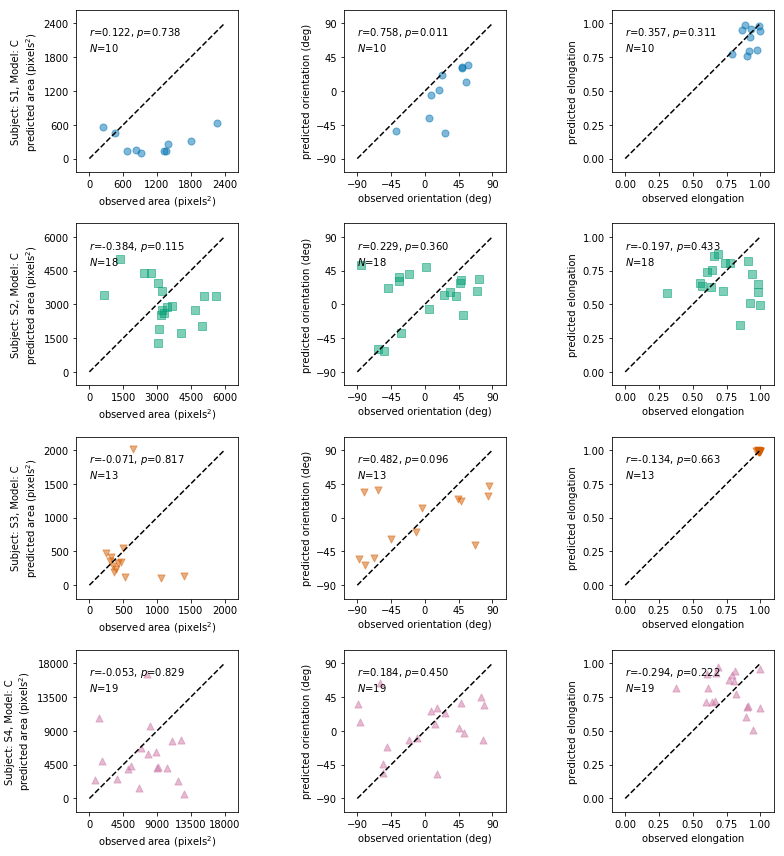

In [44]:
plotmodel = 'C'
fig, axes = plt.subplots(ncols=len(predcols), nrows=len(subjects), 
                         figsize=(12, 3 * len(subjects)))
for subject, marker, color, ticks, axrow in zip(subjects, markers, colors, all_ticks, axes):
    for _, row in best[np.logical_and(best['subject'] == subject, best['model'] == plotmodel)].iterrows():
        for col, ax, tick, label in zip(predcols, axrow, ticks, labels):
            lim = [1.1 * tick[0] - 0.1 * tick[1], 1.1 * tick[1] - 0.1 * tick[0]]
            y = row['y_test']
            y_pred = row['y_pred']
            ax.scatter(y[col], y_pred[col], marker=marker, s=50, c=color, alpha=0.5)
            ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
            ax.axis('square')
            ax.set_xticks(np.linspace(*tick, num=5))
            ax.set_yticks(np.linspace(*tick, num=5))
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
            ax.set_xlabel('observed %s' % label)
            ax.set_ylabel('predicted %s' % label)
            slope, intercept, rval, pval, _ = spst.linregress(y[col], y_pred[col])
            if pval >= 0.001:
                ax.text(tick[0], tick[1], "$r$=%.3f, $p$=%.3f\n$N$=%d\n" % (rval, pval, len(y)), 
                        va='top', ha='left')
            else:
                ax.text(tick[0], tick[1], "$r$=%.3f, $p$=%.2e\n$N$=%d" % (rval, pval, len(y)), 
                        va='top', ha='left')
    axrow[0].set_ylabel('Subject: %s, Model: %s\npredicted %s' % (subject, plotmodel, labels[0]))
fig.tight_layout()
fig.savefig('fig7-scatter-%s.eps' % plotmodel)
fig.savefig('fig7-scatter-%s.png' % plotmodel)

IndexError: index 0 is out of bounds for axis 0 with size 0

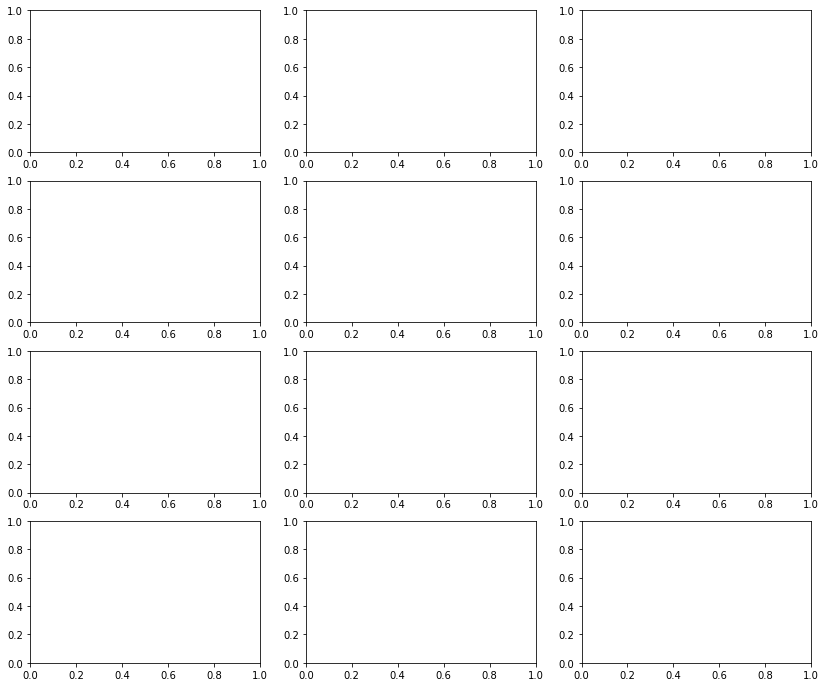

In [22]:
fig, axes = plt.subplots(nrows=len(subjects), ncols=len(predcols), figsize=(14, 3 * len(subjects)))
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    best_blob = best[np.logical_and(best['subject'] == subject, best['model'] == 'A')]
    best_axon = best[np.logical_and(best['subject'] == subject, best['model'] == 'C')]
    errb = 0
    erra = 0
    for col, ax in zip(predcols, axrow):
        yb = (best_blob['y_pred'].values[0][col] - best_blob['y_test'].values[0][col]) ** 2
        ya = (best_axon['y_pred'].values[0][col] - best_axon['y_test'].values[0][col]) ** 2
        ymax = np.max([yb.max(), ya.max()])
        errb += yb / ymax
        erra += ya / ymax
    ax.scatter(errb, erra)
    ax.plot([0, 3], [0, 3], 'k--')
    ax.set_title(col)
fig.tight_layout()

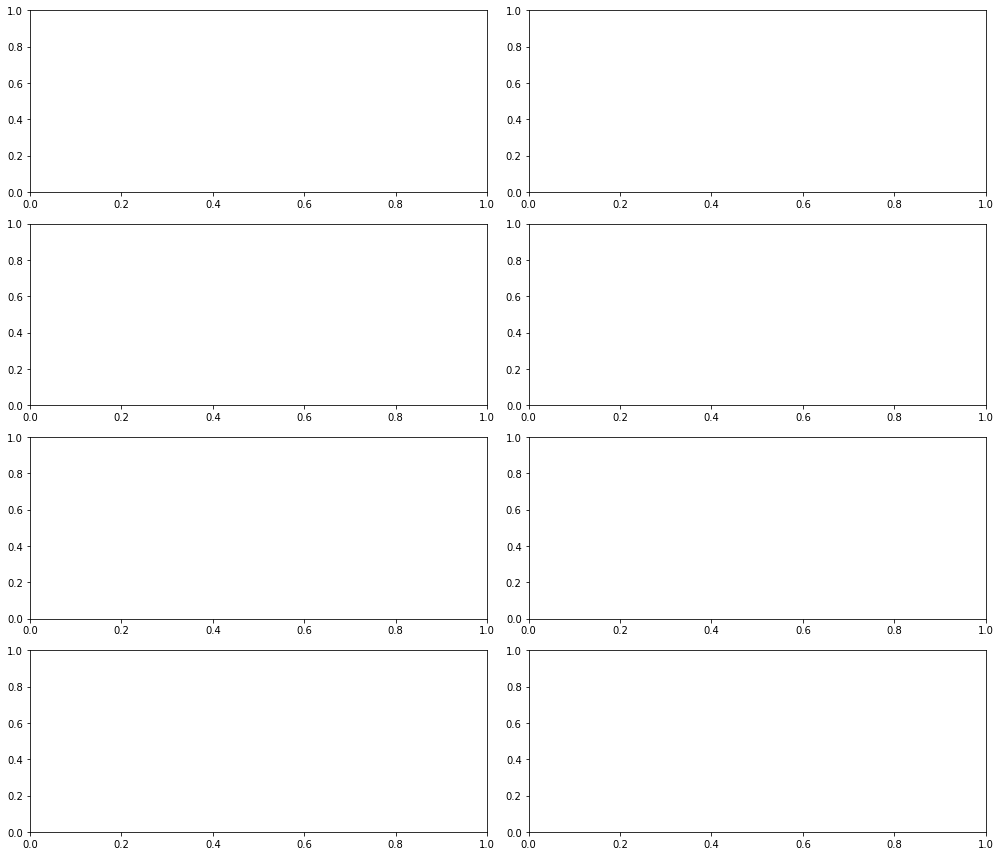

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=len(subjects), figsize=(14, 3 * len(subjects)))
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    best_blob = best[np.logical_and(best['subject'] == subject, best['model'] == 'A')]
    best_axon = best[np.logical_and(best['subject'] == subject, best['model'] == 'C')]
    for (_, fold_b), (_, fold_a) in zip(best_blob.iterrows(), best_axon.iterrows()):
        dice_b = [argus_shapes.imgproc.dice_coeff(argus_shapes.imgproc.center_phosphene(y['image']),
                                                  argus_shapes.imgproc.center_phosphene(yb['image'])) 
                  for (_, y), (_, yb) in zip(fold_b['y_test'].iterrows(), fold_b['y_pred'].iterrows())]
        dice_a = []
        angle_a = []
        for (_, y), (_, ya) in zip(fold_a['y_test'].iterrows(), fold_a['y_pred'].iterrows()):
            _, angle, dice = argus_shapes.imgproc.rd_loss(y['image'], ya['image'], return_all=True)
            dice_a.append(dice)
            angle_a.append(angle)
          
#         dice_a = [argus_shapes.imgproc.dice_coeff(argus_shapes.imgproc.center_phosphene(y['image']), 
#                                                   argus_shapes.imgproc.center_phosphene(ya['image'])) 
#                   for (_, y), (_, ya) in zip(fold_a['y_test'].iterrows(), fold_a['y_pred'].iterrows())]
        axrow[0].plot([0, 1], [0, 1], 'k--')
        axrow[0].scatter(dice_b, dice_a, marker=marker, s=50, c=color, alpha=0.5)
        axrow[0].set_xlabel('dice coefficient (scoreboard)')
        axrow[0].set_ylabel('dice coefficient (axon map)')
        axrow[0].set_title(subject)
        axrow[0].axis('square')
        
        axrow[1].scatter(angle_a, dice_a, marker=marker, s=50, c=color, alpha=0.5)
fig.tight_layout()

In [ ]:
meow

In [ ]:
img_argus1 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_i.jpg')
img_argus2 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_ii.jpg')

In [ ]:
px_argus1 = np.array([
    [  93.12857037,  162.32202802],
    [ 138.00952276,  163.7029804 ],
    [ 178.74761799,  163.01250421],
    [ 227.77142752,  161.63155183],
    [  93.12857037,  208.58393279],
    [ 143.53333228,  207.8934566 ],
    [ 182.89047514,  207.2029804 ],
    [ 227.77142752,  206.51250421],
    [  93.12857037,  251.3934566 ],
    [ 137.31904657,  251.3934566 ],
    [ 180.81904657,  251.3934566 ],
    [ 227.08095133,  251.3934566 ],
    [  93.81904657,  296.27440898],
    [ 140.08095133,  296.27440898],
    [ 182.89047514,  297.65536136],
    [ 227.08095133,  297.65536136]
])
px_argus1[:, 0] += 70
px_argus1[:, 1] -= 70

px_argus2 = np.array([
    [ 296.94026284,  140.58506571], [ 328.48148148,  138.4823178 ],
    [ 365.27956989,  140.58506571], [ 397.87216249,  139.53369176],
    [ 429.41338112,  138.4823178 ], [ 463.05734767,  140.58506571],
    [ 495.64994026,  139.53369176], [ 528.24253286,  139.53369176],
    [ 560.83512545,  139.53369176], [ 593.42771804,  138.4823178 ],
    [ 296.94026284,  173.1776583 ], [ 329.53285544,  174.22903226],
    [ 363.17682198,  173.1776583 ], [ 396.82078853,  173.1776583 ],
    [ 430.46475508,  173.1776583 ], [ 463.05734767,  174.22903226],
    [ 494.59856631,  173.1776583 ], [ 529.29390681,  174.22903226],
    [ 559.78375149,  175.28040621], [ 593.42771804,  173.1776583 ],
    [ 296.94026284,  206.82162485], [ 329.53285544,  206.82162485],
    [ 363.17682198,  205.7702509 ], [ 395.76941458,  205.7702509 ],
    [ 429.41338112,  205.7702509 ], [ 463.05734767,  208.92437276],
    [ 496.70131422,  207.87299881], [ 529.29390681,  209.97574671],
    [ 559.78375149,  208.92437276], [ 592.37634409,  206.82162485],
    [ 296.94026284,  240.4655914 ], [ 330.58422939,  240.4655914 ],
    [ 363.17682198,  240.4655914 ], [ 396.82078853,  240.4655914 ],
    [ 430.46475508,  240.4655914 ], [ 460.95459976,  240.4655914 ],
    [ 494.59856631,  242.56833931], [ 528.24253286,  239.41421744],
    [ 559.78375149,  240.4655914 ], [ 593.42771804,  241.51696535],
    [ 297.9916368 ,  274.10955795], [ 328.48148148,  273.05818399],
    [ 361.07407407,  274.10955795], [ 395.76941458,  273.05818399],
    [ 428.36200717,  274.10955795], [ 463.05734767,  273.05818399],
    [ 494.59856631,  275.1609319 ], [ 526.13978495,  274.10955795],
    [ 560.83512545,  274.10955795], [ 591.32497013,  274.10955795],
    [ 295.88888889,  306.70215054], [ 329.53285544,  305.65077658],
    [ 363.17682198,  305.65077658], [ 393.66666667,  307.75352449],
    [ 427.31063321,  307.75352449], [ 459.90322581,  305.65077658],
    [ 492.4958184 ,  308.80489845], [ 527.1911589 ,  307.75352449],
    [ 559.78375149,  307.75352449], [ 590.27359618,  306.70215054]
])

In [ ]:
def plot_phosphenes_on_array(ax, subject, Xymu, subjectdata):
    Xymu = Xymu[Xymu.subject == subject]
    implant_type = subjectdata.loc[subject, 'implant_type']
    argus = implant_type(x_center=subjectdata.loc[subject, 'implant_x'],
                         y_center=subjectdata.loc[subject, 'implant_y'],
                         rot=subjectdata.loc[subject, 'implant_rot'])
    is_argus2 = isinstance(implant_type(), p2pi.ArgusII)
    if is_argus2:
        px_argus = px_argus2
        img_argus = img_argus2
    else:
        px_argus = px_argus1
        img_argus = img_argus1    
    
    padding = 2000
    x_range = (p2pr.ret2dva(np.min([e.x_center for e in argus]) - padding),
               p2pr.ret2dva(np.max([e.x_center for e in argus]) + padding))
    y_range = (p2pr.ret2dva(np.min([e.y_center for e in argus]) - padding),
               p2pr.ret2dva(np.max([e.y_center for e in argus]) + padding))
    out_shape = Xymu.img_shape.unique()[0]  # (np.diff(y_range)[0] * 10, np.diff(x_range)[0] * 10)
    pts_in = []
    pts_dva = []
    pts_out = []
    for xy, e in zip(px_argus, argus):
        pts_in.append(xy)
        dva = p2pr.ret2dva([e.x_center, e.y_center])
        pts_dva.append(dva)
        xout = (dva[0] - x_range[0]) / (x_range[1] - x_range[0]) * (out_shape[1] - 1)
        yout = (dva[1] - y_range[0]) / (y_range[1] - y_range[0]) * (out_shape[0] - 1)
        pts_out.append([xout, yout])
    argus2dva = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_dva))
    dva2out = skit.estimate_transform('similarity', np.array(pts_dva), np.array(pts_out))
    argus2out = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_out))
    
    # top left, top right, bottom left, bottom right
    pts_draw = [[0, 0], [0, out_shape[1] - 1],
                [out_shape[0] - 1, 0], [out_shape[1] - 1, out_shape[0] - 1]]
    x_range = subjectdata.loc[subject, 'xrange']
    y_range = subjectdata.loc[subject, 'yrange']
    pts_dva = [[x_range[0], y_range[0]], [x_range[0], y_range[1]],
               [x_range[1], y_range[0]], [x_range[1], y_range[1]]]
    draw2dva = skit.estimate_transform('similarity', np.array(pts_draw), np.array(pts_dva))

    all_imgs = np.zeros(out_shape)
    for _, row in Xymu.iterrows():
        e_pos = p2pr.ret2dva((argus[row['electrode']].x_center, argus[row['electrode']].y_center))
        align_center = dva2out(e_pos)[0]
        img_drawing = argus_shapes.imgproc.scale_phosphene(row['image'], subjectdata.loc[subject, 'scale'])
        img_drawing = argus_shapes.imgproc.center_phosphene(img_drawing, center=align_center[::-1])
        all_imgs += img_drawing
    all_imgs = np.maximum(0, np.minimum(1, 1 - all_imgs))
    ax.imshow(np.ma.masked_where(all_imgs > 0.5, all_imgs), vmin=0, vmax=1, cmap='gray')
    ax.imshow(skit.warp(img_argus, argus2out.inverse, cval=1.0, output_shape=out_shape), alpha=0.3)
    
    fovea = fovea = dva2out([0, 0])[0]
    ax.scatter(fovea[0], fovea[1], s=100, marker='s', c='w', edgecolors='k')

In [ ]:
fig, axes = plt.subplots(nrows=len(subjects), ncols=3, figsize=(12, 3 * len(subjects)))
for subject, axrow in zip(subjects, axes):
    for model, col, ax in zip(['A', 'A', 'C'], ['y_test', 'y_pred', 'y_pred'], axrow):
        yp = best[np.logical_and(best['subject'] == subject, best['model'] == model)][col].values[0]
        yp['subject'] = pd.Series([subject for _, _ in yp.iterrows()], index=yp.index)
        plot_phosphenes_on_array(ax, subject, yp, subjectdata)
        ax.set_xticks([])
        ax.set_yticks([])
    axrow[0].set_ylabel(subject, fontsize=16)
fig.savefig('fig7-model-scatter.png')